<a href="https://colab.research.google.com/github/TheRadDani/AI/blob/main/DistributedTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Mar 27 16:45:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy 

In [5]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
X_train.shape

(50000, 32, 32, 3)

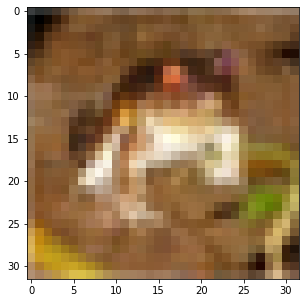

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.imshow(X_train[0],cmap='cividis')
plt.show()

In [15]:
classes = ["airplane","automobile","bird","cat","deer","dog","forg","horse","ship","truck"]

In [18]:
y_train.shape

(50000, 1)

In [20]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

Numpy Broadcasting example

In [29]:
scalar_arr = y_train.sum(1)
scalar_arr.shape

(50000,)

In [30]:
scalar_arr = y_train.sum(1,keepdims=True)
scalar_arr.shape

(50000, 1)

In [35]:
scalar_arr_broadcast = y_train + 1
scalar_arr_broadcast.shape

(50000, 1)

In [40]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [41]:
y_train_categorical = keras.utils.to_categorical(
    y_train, num_classes = 10, dtype="float32"
)
y_test_categorical = keras.utils.to_categorical(
    y_test,num_classes=10,dtype="float32"
)

One-hot representation

In [43]:
y_test_categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [64]:
def get_model():
  model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
  ])  
  model.compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model

In [42]:
train_tf_dataset =  tf.data.Dataset.from_tensor_slices((X_train_scaled,y_train_categorical))
test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled,y_test_categorical))

In [44]:
type(train_tf_dataset)

tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset

Mirror strategy for distributed training

In [46]:
strategy = tf.distribute.MirroredStrategy()

In [50]:
replicas = strategy.num_replicas_in_sync

In [51]:
BATCH_SIZE_PER_REPLICA = 1000
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * replicas

In [54]:
train_dataset = train_tf_dataset.batch(BATCH_SIZE_PER_REPLICA).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf_dataset.batch(BATCH_SIZE_PER_REPLICA)

In [65]:
%%timeit -n1 -r1
with strategy.scope():
  gpu_model = get_model()
  gpu_model.fit(train_dataset,epochs = 50)

Epoch 1/50
50/50 [==============================] - 14s 81ms/step - loss: 1.9332 - accuracy: 0.2905
Epoch 2/50
50/50 [==============================] - 4s 84ms/step - loss: 1.5276 - accuracy: 0.4454
Epoch 3/50
50/50 [==============================] - 4s 84ms/step - loss: 1.3816 - accuracy: 0.5058
Epoch 4/50
50/50 [==============================] - 4s 87ms/step - loss: 1.2520 - accuracy: 0.5529
Epoch 5/50
50/50 [==============================] - 4s 84ms/step - loss: 1.1612 - accuracy: 0.5851
Epoch 6/50
50/50 [==============================] - 4s 87ms/step - loss: 1.0850 - accuracy: 0.6157
Epoch 7/50
50/50 [==============================] - 4s 84ms/step - loss: 1.0279 - accuracy: 0.6368
Epoch 8/50
50/50 [==============================] - 4s 83ms/step - loss: 0.9640 - accuracy: 0.6602
Epoch 9/50
50/50 [==============================] - 4s 83ms/step - loss: 0.9108 - accuracy: 0.6775
Epoch 10/50
50/50 [==============================] - 4s 87ms/step - loss: 0.8827 - accuracy: 0.6909
Epoch 11

Time training on CPU

In [1]:
%%timeit -n1 -r1
with tf.device('/CPU:0'):
  cpu_model = get_model()
  cpu_model.fit(train_dataset,epochs = 50)

NameError: ignored